# Vision and Cognitive Systems Project

## Import libraries and connection to Google Drive

In [ ]:
################
#### Import ####
################

from google.colab import drive
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
import albumentations
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib
from tqdm import tqdm
import pandas as pd

import skimage
from skimage import img_as_ubyte, img_as_float32

from glob import glob

np.random.seed(108)

plt.style.use('default')
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
visualize = False

### Connection to Google Drive

The connection to Google Drive is necessary to use the dataset. You must have the dataset stored on your Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Download Dataset

In [ ]:
################
# load Pascal VOC dataset
################

!tar -xvf "gdrive/MyDrive/Dataset/VOC2012.tar"

Output streaming troncato alle ultime 5000 righe.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC2

### Datasets creation for Context Prediction and Image Classification

In [ ]:
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow']

In [ ]:
dataset = []
class_counters = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for c in classes:
  f = open(f'VOCdevkit/VOC2012/ImageSets/Main/{c}_trainval.txt', 'r')
  
  for line in f:
    splitted = line.split('  ')

    if len(splitted) == 2:
      dataset.append([f'VOCdevkit/VOC2012/JPEGImages/{splitted[0]}.jpg', c])
      class_counters[classes.index(c)] += 1
    
df_dataset = pd.DataFrame(data=dataset, columns=['filename', 'class'])

In [ ]:
print(f'Images per class: {class_counters}')
print(f'Total images: {sum(class_counters)}')

Images per class: [676, 571, 773, 516, 768, 430, 1229, 1084, 1298, 309]
Total images: 7654


In [ ]:
print(df_dataset)

                                          filename      class
0     VOCdevkit/VOC2012/JPEGImages/2008_000021.jpg  aeroplane
1     VOCdevkit/VOC2012/JPEGImages/2008_000033.jpg  aeroplane
2     VOCdevkit/VOC2012/JPEGImages/2008_000037.jpg  aeroplane
3     VOCdevkit/VOC2012/JPEGImages/2008_000064.jpg  aeroplane
4     VOCdevkit/VOC2012/JPEGImages/2008_000151.jpg  aeroplane
...                                            ...        ...
7649  VOCdevkit/VOC2012/JPEGImages/2011_002937.jpg        cow
7650  VOCdevkit/VOC2012/JPEGImages/2011_002979.jpg        cow
7651  VOCdevkit/VOC2012/JPEGImages/2011_003016.jpg        cow
7652  VOCdevkit/VOC2012/JPEGImages/2011_003019.jpg        cow
7653  VOCdevkit/VOC2012/JPEGImages/2011_003043.jpg        cow

[7654 rows x 2 columns]


In [ ]:
df_context_prediction = pd.DataFrame(data=[], columns=['filename', 'class'])
df_image_classification = pd.DataFrame(data=[], columns=['filename', 'class'])

for c in classes:
  total_images_for_class_c = len(df_dataset.loc[df_dataset['class'] == c])

  df_context_prediction = pd.concat([df_context_prediction, df_dataset.loc[df_dataset['class'] == c][: int(total_images_for_class_c * 0.3)]])
  df_image_classification = pd.concat([df_image_classification, df_dataset.loc[df_dataset['class'] == c][int(total_images_for_class_c * 0.3):]])

In [ ]:
print(df_context_prediction)

                                          filename      class
0     VOCdevkit/VOC2012/JPEGImages/2008_000021.jpg  aeroplane
1     VOCdevkit/VOC2012/JPEGImages/2008_000033.jpg  aeroplane
2     VOCdevkit/VOC2012/JPEGImages/2008_000037.jpg  aeroplane
3     VOCdevkit/VOC2012/JPEGImages/2008_000064.jpg  aeroplane
4     VOCdevkit/VOC2012/JPEGImages/2008_000151.jpg  aeroplane
...                                            ...        ...
7432  VOCdevkit/VOC2012/JPEGImages/2009_000626.jpg        cow
7433  VOCdevkit/VOC2012/JPEGImages/2009_000632.jpg        cow
7434  VOCdevkit/VOC2012/JPEGImages/2009_000641.jpg        cow
7435  VOCdevkit/VOC2012/JPEGImages/2009_000694.jpg        cow
7436  VOCdevkit/VOC2012/JPEGImages/2009_000709.jpg        cow

[2291 rows x 2 columns]


In [ ]:
print(df_image_classification)

                                          filename      class
202   VOCdevkit/VOC2012/JPEGImages/2008_008050.jpg  aeroplane
203   VOCdevkit/VOC2012/JPEGImages/2008_008053.jpg  aeroplane
204   VOCdevkit/VOC2012/JPEGImages/2008_008086.jpg  aeroplane
205   VOCdevkit/VOC2012/JPEGImages/2008_008096.jpg  aeroplane
206   VOCdevkit/VOC2012/JPEGImages/2008_008130.jpg  aeroplane
...                                            ...        ...
7649  VOCdevkit/VOC2012/JPEGImages/2011_002937.jpg        cow
7650  VOCdevkit/VOC2012/JPEGImages/2011_002979.jpg        cow
7651  VOCdevkit/VOC2012/JPEGImages/2011_003016.jpg        cow
7652  VOCdevkit/VOC2012/JPEGImages/2011_003019.jpg        cow
7653  VOCdevkit/VOC2012/JPEGImages/2011_003043.jpg        cow

[5363 rows x 2 columns]


### Datasets

*df_context_prediction* => 10 classes, 2291 images of different classes

*df_image_classification* => 10 classes, 5363 images of different classes

*classes* => ID of the used classes

<br>

Note: *df_context_prediction* and *df_image_classification* contain different images

## Useful Functions

In [ ]:
##########################
###  Useful functions  ###
##########################

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
def convert_format(data, format):
  if format == 'p':
    return np.transpose(data, (0, 3, 1, 2))
  if format == 'n':
    return np.transpose(data, (0, 2, 3, 1))
  if format == '3':
    return np.transpose(data, (1, 2, 0))

### Plot Functions

In [ ]:
def loss_plot(train_loss, val_loss, model_name, top_y = 2.3, bottom_y = 1.8):
  plt.plot(range(len(train_loss)), train_loss, label='TRAIN Loss', color='blue')
  plt.plot(range(len(val_loss)), val_loss, label='VAL Loss', color='green')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(top=top_y)
  plt.ylim(bottom=bottom_y)
  plt.title(f'Training and Validation Loss - {model_name}')
  plt.legend()
  plt.show()

In [ ]:
def accuracy_plot(accuracy, model_name):
  accuracy = [i.item() for i in accuracy]
  plt.plot(range(len(accuracy)), accuracy, label='Accuracy', color='green')
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.title(f'Validation accuracy - {model_name}')
  plt.legend()
  plt.show()

## Context Prediction

#### The Task

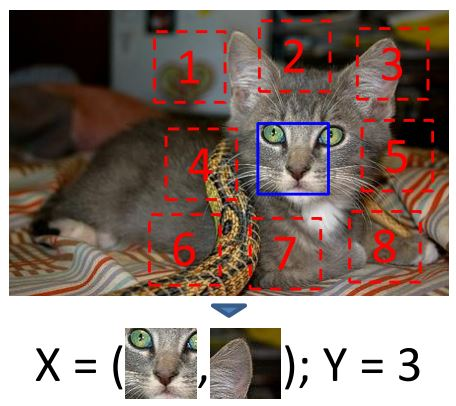 <br> <br>
The task is sample the central patch and a random patch in one of the eight spatial configurations, and present each pair of patches to a machine learner, providing no information about the second patch original position within the image. The algorithm must then guess the position of one patch relative to the other. As stated on the paper "Unsupervised Visual Representation Learning by Context Prediction (Carl Doersch, Abhinav Gupta, Alexei A. Efros)" doing well on this task requires understanding scenes and objects, i.e. a good visual representation for this task will need to extract objects and their parts in order to reason about their relative spatial location.

#### Training and Validation Set creation

In [ ]:
# X immages for each class => 80% of X training - 20% of X validation

df_context_prediction_train = pd.DataFrame(data=[], columns=['filename', 'class'])
df_context_prediction_val = pd.DataFrame(data=[], columns=['filename', 'class'])

for c in classes:
  total_images_for_class_c = len(df_context_prediction.loc[df_context_prediction['class'] == c])

  df_context_prediction_train = pd.concat([df_context_prediction_train, df_context_prediction.loc[df_context_prediction['class'] == c][:int(total_images_for_class_c * 0.8)]])
  df_context_prediction_val = pd.concat([df_context_prediction_val, df_context_prediction.loc[df_context_prediction['class'] == c][int(total_images_for_class_c * 0.8):]])

In [ ]:
print(df_context_prediction_train)

                                          filename      class
0     VOCdevkit/VOC2012/JPEGImages/2008_000021.jpg  aeroplane
1     VOCdevkit/VOC2012/JPEGImages/2008_000033.jpg  aeroplane
2     VOCdevkit/VOC2012/JPEGImages/2008_000037.jpg  aeroplane
3     VOCdevkit/VOC2012/JPEGImages/2008_000064.jpg  aeroplane
4     VOCdevkit/VOC2012/JPEGImages/2008_000151.jpg  aeroplane
...                                            ...        ...
7413  VOCdevkit/VOC2012/JPEGImages/2008_008482.jpg        cow
7414  VOCdevkit/VOC2012/JPEGImages/2008_008521.jpg        cow
7415  VOCdevkit/VOC2012/JPEGImages/2008_008541.jpg        cow
7416  VOCdevkit/VOC2012/JPEGImages/2008_008617.jpg        cow
7417  VOCdevkit/VOC2012/JPEGImages/2008_008635.jpg        cow

[1829 rows x 2 columns]


In [ ]:
print(df_context_prediction_val)

                                          filename      class
161   VOCdevkit/VOC2012/JPEGImages/2008_006933.jpg  aeroplane
162   VOCdevkit/VOC2012/JPEGImages/2008_006951.jpg  aeroplane
163   VOCdevkit/VOC2012/JPEGImages/2008_006980.jpg  aeroplane
164   VOCdevkit/VOC2012/JPEGImages/2008_007095.jpg  aeroplane
165   VOCdevkit/VOC2012/JPEGImages/2008_007096.jpg  aeroplane
...                                            ...        ...
7432  VOCdevkit/VOC2012/JPEGImages/2009_000626.jpg        cow
7433  VOCdevkit/VOC2012/JPEGImages/2009_000632.jpg        cow
7434  VOCdevkit/VOC2012/JPEGImages/2009_000641.jpg        cow
7435  VOCdevkit/VOC2012/JPEGImages/2009_000694.jpg        cow
7436  VOCdevkit/VOC2012/JPEGImages/2009_000709.jpg        cow

[462 rows x 2 columns]


#### Training Function

In [ ]:
##############################
# Training/Validation Engine #
##############################

def model_training(model, optimizer, criterion, scheduler, model_name):
  global_trn_loss = []
  global_val_loss = []
  accuracy = []

  for epoch in range(Config.num_epochs):
      train_running_loss = []
      val_running_loss = []
      start_time = time.time()
      model.train()
      for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config.batch_size)):
          uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
          optimizer.zero_grad()
          output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
          loss = criterion(output, random_patch_label)
          loss.backward()
          optimizer.step()
          
          train_running_loss.append(loss.item())
      else:
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset)/Config.batch_size)):
            uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
            output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
            loss = criterion(output, random_patch_label)
            val_running_loss.append(loss.item())
          
            _, predicted = torch.max(output.data, 1)
            total += random_patch_label.size(0)
            correct += (predicted == random_patch_label).sum()
          print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
          print('Val accuracy: {:.3f}%'.format(100 * correct / total))

      global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
      global_val_loss.append(sum(val_running_loss) / len(val_running_loss))
      accuracy.append(100 * correct / total)

      scheduler.step(global_val_loss[-1])

      print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
          epoch + 1, Config.num_epochs, global_trn_loss[-1], global_val_loss[-1],
          (time.time() - start_time) / 60))
      
  MODEL_SAVE_PATH = f'/content/model_{model_name}.pt'
  torch.save(
    {
      'epoch': Config.num_epochs,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      'global_trnloss': global_trn_loss,
      'global_valloss': global_val_loss,
      'accuracy' : accuracy
    }, MODEL_SAVE_PATH)

#### Patches 3x3

##### Config

In [ ]:
############################################
#### Configuration #### 
############################################

class Config():
  patch_dim = 60
  gap = 10
  batch_size = 64
  num_epochs = 20
  lr = 0.0005

##### MyDataset Class

In [ ]:
###################################################
#### This class generates patches for training ####
###################################################

class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform
    self.train_data = df.values
  
  def get_patch_from_grid(self, image, patch_dim, gap):
    offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]
    
    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
    patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
    random_patch_label = loc
    
    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = Image.open(self.train_data[index]).convert('RGB')
    image = np.array(image)
    image = skimage.transform.resize(image, (222, 222))

    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, 
                                                                               self.patch_dim, 
                                                                               self.gap)
    if uniform_patch.shape[0] != 222:
        uniform_patch = skimage.transform.resize(uniform_patch, (222, 222))
        random_patch = skimage.transform.resize(random_patch, (222, 222))
        
        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    random_patch_label = np.array(random_patch_label).astype(np.int64)
        
    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label

##### Datasets Loaders

In [ ]:
##########################################################
#### Creating Train/Validation dataset and dataloader ####
##########################################################

traindataset = MyDataset(Config.patch_dim, Config.gap, df_context_prediction_train['filename'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config.batch_size,
                                          shuffle=True)

valdataset = MyDataset(Config.patch_dim, Config.gap, df_context_prediction_val['filename'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

##### Datasets Visualization

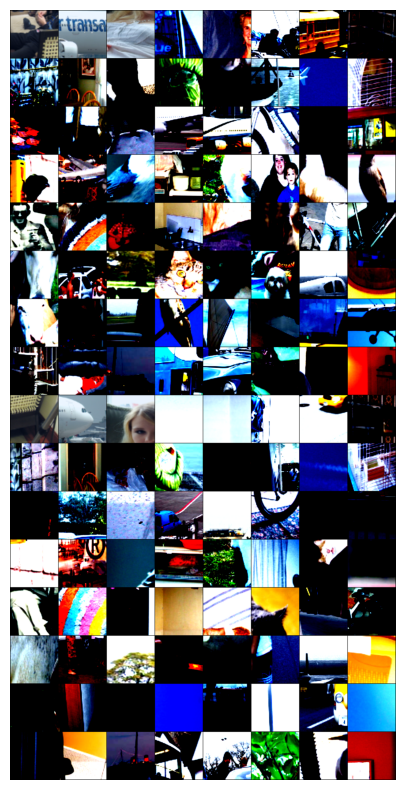

Labels: [7 4 1 4 0 0 6 0 2 3 5 4 7 6 4 6 0 2 5 5 2 7 2 6 6 3 3 5 6 2 6 2 6 6 4 1 1
 2 2 2 3 6 1 0 7 7 4 6 0 5 7 7 6 0 5 6 4 4 4 2 1 0 3 2]


In [ ]:
######################################
#### Visualizing training dataset ####
######################################

example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

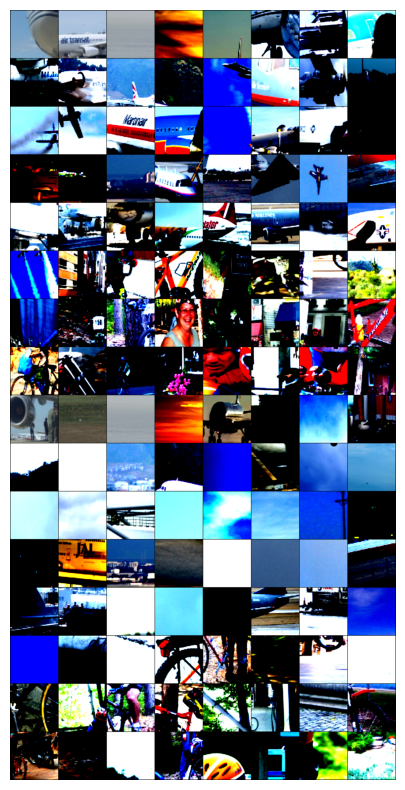

Labels: [6 7 4 6 6 7 0 4 2 2 3 3 3 5 6 1 5 0 2 0 5 1 0 2 3 6 3 5 1 1 1 3 5 3 0 0 5
 4 7 1 0 5 7 3 6 4 4 2 6 1 4 7 2 7 5 4 3 4 2 5 1 2 7 5]


In [ ]:
########################################
#### Visualizing validation dataset ####
########################################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[2].numpy()}')

##### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(2304, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

baseline_model = BaselineModel().to(device)

###### Baseline Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline')

29it [01:36,  3.34s/it]
8it [00:22,  2.81s/it]


Val Progress --- total:462, correct:85
Val accuracy: 18.398%
Epoch [1/20], TRNLoss:2.2304, VALLoss:2.0745, Time:1.99


29it [01:35,  3.30s/it]
8it [00:24,  3.00s/it]


Val Progress --- total:462, correct:76
Val accuracy: 16.450%
Epoch [2/20], TRNLoss:2.0397, VALLoss:2.0150, Time:1.99


29it [01:34,  3.26s/it]
8it [00:22,  2.76s/it]


Val Progress --- total:462, correct:91
Val accuracy: 19.697%
Epoch [3/20], TRNLoss:2.0248, VALLoss:2.0247, Time:1.95


29it [01:34,  3.27s/it]
8it [00:23,  2.88s/it]


Val Progress --- total:462, correct:103
Val accuracy: 22.294%
Epoch [4/20], TRNLoss:1.9979, VALLoss:1.9666, Time:1.97


29it [01:41,  3.50s/it]
8it [00:25,  3.14s/it]


Val Progress --- total:462, correct:84
Val accuracy: 18.182%
Epoch [5/20], TRNLoss:1.9872, VALLoss:1.9950, Time:2.11


29it [01:33,  3.22s/it]
8it [00:23,  2.96s/it]


Val Progress --- total:462, correct:83
Val accuracy: 17.965%
Epoch [6/20], TRNLoss:1.9579, VALLoss:1.9993, Time:1.95


29it [01:31,  3.17s/it]
8it [00:21,  2.71s/it]


Val Progress --- total:462, correct:102
Val accuracy: 22.078%
Epoch [7/20], TRNLoss:1.9533, VALLoss:1.9571, Time:1.89


29it [01:33,  3.21s/it]
8it [00:23,  2.90s/it]


Val Progress --- total:462, correct:100
Val accuracy: 21.645%
Epoch [8/20], TRNLoss:1.9614, VALLoss:1.9350, Time:1.94


29it [01:32,  3.18s/it]
8it [00:22,  2.80s/it]


Val Progress --- total:462, correct:124
Val accuracy: 26.840%
Epoch [9/20], TRNLoss:1.9317, VALLoss:1.9158, Time:1.91


29it [01:32,  3.18s/it]
8it [00:21,  2.68s/it]


Val Progress --- total:462, correct:109
Val accuracy: 23.593%
Epoch [10/20], TRNLoss:1.9264, VALLoss:1.8762, Time:1.90


29it [01:34,  3.26s/it]
8it [00:22,  2.84s/it]


Val Progress --- total:462, correct:86
Val accuracy: 18.615%
Epoch [11/20], TRNLoss:1.9152, VALLoss:1.9398, Time:1.96


29it [01:34,  3.25s/it]
8it [00:21,  2.66s/it]


Val Progress --- total:462, correct:121
Val accuracy: 26.190%
Epoch [12/20], TRNLoss:1.8940, VALLoss:1.8731, Time:1.93


29it [01:31,  3.17s/it]
8it [00:21,  2.70s/it]


Val Progress --- total:462, correct:107
Val accuracy: 23.160%
Epoch [13/20], TRNLoss:1.9074, VALLoss:1.9283, Time:1.89


29it [01:31,  3.16s/it]
8it [00:23,  2.88s/it]


Val Progress --- total:462, correct:110
Val accuracy: 23.810%
Epoch [14/20], TRNLoss:1.8651, VALLoss:1.9647, Time:1.91


29it [01:30,  3.13s/it]
8it [00:22,  2.85s/it]


Val Progress --- total:462, correct:121
Val accuracy: 26.190%
Epoch [15/20], TRNLoss:1.8938, VALLoss:1.8770, Time:1.89


29it [01:33,  3.21s/it]
8it [00:21,  2.65s/it]


Val Progress --- total:462, correct:137
Val accuracy: 29.654%
Epoch [16/20], TRNLoss:1.8908, VALLoss:1.8498, Time:1.91


29it [01:32,  3.20s/it]
8it [00:22,  2.85s/it]


Val Progress --- total:462, correct:126
Val accuracy: 27.273%
Epoch [17/20], TRNLoss:1.8580, VALLoss:1.8247, Time:1.92


29it [01:30,  3.13s/it]
8it [00:23,  2.94s/it]


Val Progress --- total:462, correct:124
Val accuracy: 26.840%
Epoch [18/20], TRNLoss:1.8709, VALLoss:1.9097, Time:1.91


29it [01:34,  3.26s/it]
8it [00:21,  2.68s/it]


Val Progress --- total:462, correct:121
Val accuracy: 26.190%
Epoch [19/20], TRNLoss:1.8488, VALLoss:1.9114, Time:1.93


29it [01:32,  3.18s/it]
8it [00:23,  2.88s/it]


Val Progress --- total:462, correct:116
Val accuracy: 25.108%
Epoch [20/20], TRNLoss:1.8527, VALLoss:1.8605, Time:1.92


###### Baseline Model training and validation plots

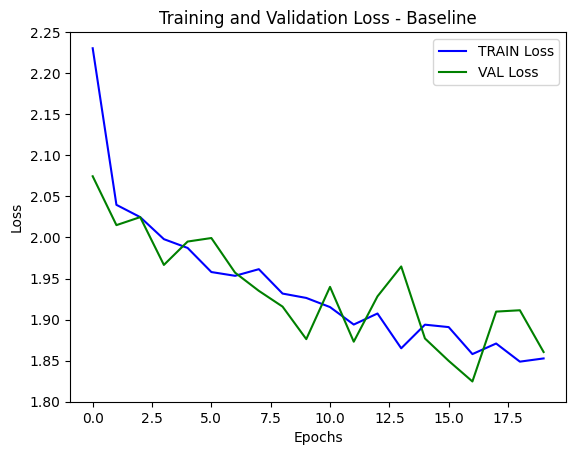

In [ ]:
checkpoint = torch.load('/content/model_baseline.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline', top_y=2.25, bottom_y=1.8)

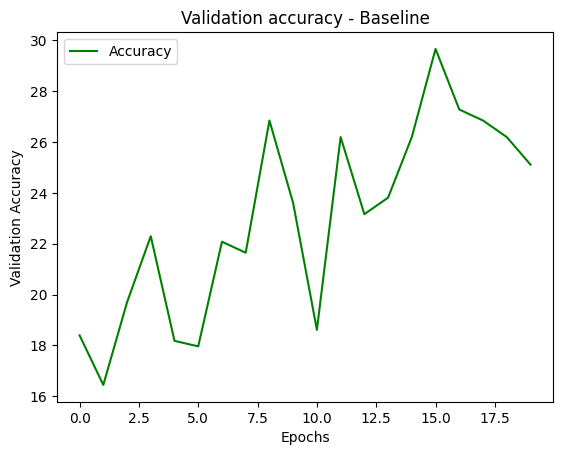

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline')

##### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(2304, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

alexnet_model = AlexNetwork().to(device)

###### AlexNet Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet')

29it [01:34,  3.26s/it]
8it [00:23,  2.88s/it]


Val Progress --- total:462, correct:74
Val accuracy: 16.017%
Epoch [1/20], TRNLoss:2.2077, VALLoss:2.0834, Time:1.96


29it [01:34,  3.25s/it]
8it [00:22,  2.78s/it]


Val Progress --- total:462, correct:72
Val accuracy: 15.584%
Epoch [2/20], TRNLoss:2.0659, VALLoss:2.0644, Time:1.94


29it [01:31,  3.15s/it]
8it [00:22,  2.81s/it]


Val Progress --- total:462, correct:79
Val accuracy: 17.100%
Epoch [3/20], TRNLoss:2.0364, VALLoss:2.0213, Time:1.90


29it [01:29,  3.09s/it]
8it [00:22,  2.81s/it]


Val Progress --- total:462, correct:71
Val accuracy: 15.368%
Epoch [4/20], TRNLoss:2.0383, VALLoss:2.0203, Time:1.87


29it [01:32,  3.17s/it]
8it [00:21,  2.68s/it]


Val Progress --- total:462, correct:84
Val accuracy: 18.182%
Epoch [5/20], TRNLoss:2.0077, VALLoss:2.0374, Time:1.89


29it [01:32,  3.20s/it]
8it [00:22,  2.79s/it]


Val Progress --- total:462, correct:83
Val accuracy: 17.965%
Epoch [6/20], TRNLoss:2.0151, VALLoss:1.9619, Time:1.92


29it [01:32,  3.18s/it]
8it [00:22,  2.87s/it]


Val Progress --- total:462, correct:83
Val accuracy: 17.965%
Epoch [7/20], TRNLoss:1.9977, VALLoss:2.0379, Time:1.92


29it [01:33,  3.21s/it]
8it [00:21,  2.65s/it]


Val Progress --- total:462, correct:89
Val accuracy: 19.264%
Epoch [8/20], TRNLoss:1.9992, VALLoss:2.0985, Time:1.91


29it [01:32,  3.20s/it]
8it [00:22,  2.81s/it]


Val Progress --- total:462, correct:89
Val accuracy: 19.264%
Epoch [9/20], TRNLoss:1.9796, VALLoss:2.0330, Time:1.92


29it [01:32,  3.20s/it]
8it [00:23,  2.88s/it]


Val Progress --- total:462, correct:91
Val accuracy: 19.697%
Epoch [10/20], TRNLoss:1.9753, VALLoss:1.9819, Time:1.93


29it [01:32,  3.20s/it]
8it [00:21,  2.67s/it]


Val Progress --- total:462, correct:68
Val accuracy: 14.719%
Epoch [11/20], TRNLoss:1.9688, VALLoss:2.0621, Time:1.90


29it [01:32,  3.18s/it]
8it [00:21,  2.68s/it]


Val Progress --- total:462, correct:95
Val accuracy: 20.563%
Epoch 00012: reducing learning rate of group 0 to 1.5000e-04.
Epoch [12/20], TRNLoss:1.9796, VALLoss:1.9764, Time:1.89


29it [01:31,  3.17s/it]
8it [00:22,  2.85s/it]


Val Progress --- total:462, correct:102
Val accuracy: 22.078%
Epoch [13/20], TRNLoss:1.9421, VALLoss:1.9793, Time:1.91


29it [01:30,  3.14s/it]
8it [00:23,  2.89s/it]


Val Progress --- total:462, correct:109
Val accuracy: 23.593%
Epoch [14/20], TRNLoss:1.9046, VALLoss:1.9443, Time:1.90


29it [01:32,  3.19s/it]
8it [00:21,  2.63s/it]


Val Progress --- total:462, correct:107
Val accuracy: 23.160%
Epoch [15/20], TRNLoss:1.9113, VALLoss:1.9344, Time:1.89


29it [01:33,  3.21s/it]
8it [00:23,  2.92s/it]


Val Progress --- total:462, correct:111
Val accuracy: 24.026%
Epoch [16/20], TRNLoss:1.8988, VALLoss:1.8745, Time:1.94


29it [01:31,  3.15s/it]
8it [00:22,  2.81s/it]


Val Progress --- total:462, correct:112
Val accuracy: 24.242%
Epoch [17/20], TRNLoss:1.8920, VALLoss:1.9119, Time:1.90


29it [01:30,  3.13s/it]
8it [00:22,  2.76s/it]


Val Progress --- total:462, correct:121
Val accuracy: 26.190%
Epoch [18/20], TRNLoss:1.8845, VALLoss:1.9370, Time:1.88


29it [01:31,  3.15s/it]
8it [00:21,  2.66s/it]


Val Progress --- total:462, correct:126
Val accuracy: 27.273%
Epoch [19/20], TRNLoss:1.8617, VALLoss:1.8083, Time:1.87


29it [01:31,  3.16s/it]
8it [00:21,  2.72s/it]


Val Progress --- total:462, correct:121
Val accuracy: 26.190%
Epoch [20/20], TRNLoss:1.8485, VALLoss:1.8975, Time:1.89


###### AlexNet training and validation plots

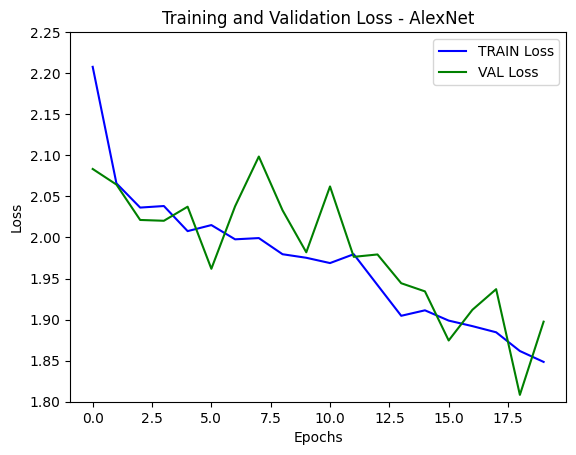

In [ ]:
checkpoint = torch.load('/content/model_alexnet.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet', top_y=2.25, bottom_y=1.8)

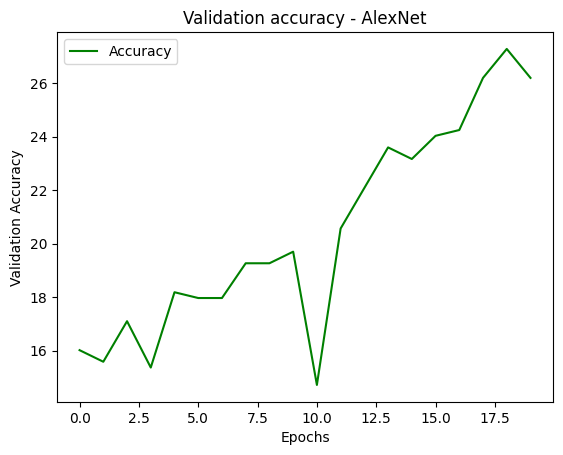

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet')

##### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(18432, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

vgg_model = VggNet().to(device)

###### VGG Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'VGGNet')

29it [02:20,  4.83s/it]
8it [00:26,  3.27s/it]


Val Progress --- total:462, correct:63
Val accuracy: 13.636%
Epoch [1/20], TRNLoss:2.0843, VALLoss:2.0805, Time:2.77


29it [02:20,  4.84s/it]
8it [00:25,  3.25s/it]


Val Progress --- total:462, correct:58
Val accuracy: 12.554%
Epoch [2/20], TRNLoss:2.0825, VALLoss:9.4341, Time:2.77


29it [02:19,  4.82s/it]
8it [00:26,  3.29s/it]


Val Progress --- total:462, correct:55
Val accuracy: 11.905%
Epoch [3/20], TRNLoss:2.0684, VALLoss:25.9055, Time:2.77


29it [02:21,  4.87s/it]
8it [00:26,  3.36s/it]


Val Progress --- total:462, correct:52
Val accuracy: 11.255%
Epoch [4/20], TRNLoss:2.0882, VALLoss:50.6243, Time:2.80


29it [02:21,  4.88s/it]
8it [00:26,  3.30s/it]


Val Progress --- total:462, correct:59
Val accuracy: 12.771%
Epoch [5/20], TRNLoss:2.0919, VALLoss:3.9170, Time:2.80


29it [02:22,  4.91s/it]
8it [00:26,  3.32s/it]


Val Progress --- total:462, correct:52
Val accuracy: 11.255%
Epoch [6/20], TRNLoss:2.0776, VALLoss:9.6399, Time:2.82


29it [02:22,  4.91s/it]
8it [00:27,  3.41s/it]


Val Progress --- total:462, correct:66
Val accuracy: 14.286%
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.
Epoch [7/20], TRNLoss:2.0641, VALLoss:11.3348, Time:2.83


29it [02:21,  4.87s/it]
8it [00:26,  3.31s/it]


Val Progress --- total:462, correct:77
Val accuracy: 16.667%
Epoch [8/20], TRNLoss:2.0303, VALLoss:2.0765, Time:2.80


29it [02:19,  4.82s/it]
8it [00:26,  3.29s/it]


Val Progress --- total:462, correct:59
Val accuracy: 12.771%
Epoch [9/20], TRNLoss:2.0409, VALLoss:2.2596, Time:2.77


29it [02:19,  4.81s/it]
8it [00:26,  3.32s/it]


Val Progress --- total:462, correct:61
Val accuracy: 13.203%
Epoch [10/20], TRNLoss:2.0152, VALLoss:2.5985, Time:2.77


29it [02:18,  4.77s/it]
8it [00:26,  3.29s/it]


Val Progress --- total:462, correct:64
Val accuracy: 13.853%
Epoch [11/20], TRNLoss:1.9927, VALLoss:4.7329, Time:2.75


29it [02:20,  4.85s/it]
8it [00:26,  3.29s/it]


Val Progress --- total:462, correct:52
Val accuracy: 11.255%
Epoch [12/20], TRNLoss:1.9863, VALLoss:2.1669, Time:2.78


29it [02:18,  4.76s/it]
8it [00:26,  3.33s/it]


Val Progress --- total:462, correct:62
Val accuracy: 13.420%
Epoch [13/20], TRNLoss:1.9912, VALLoss:2.8690, Time:2.75


29it [02:18,  4.79s/it]
8it [00:26,  3.31s/it]


Val Progress --- total:462, correct:57
Val accuracy: 12.338%
Epoch 00014: reducing learning rate of group 0 to 4.5000e-05.
Epoch [14/20], TRNLoss:1.9693, VALLoss:2.2797, Time:2.76


29it [02:20,  4.84s/it]
8it [00:26,  3.29s/it]


Val Progress --- total:462, correct:102
Val accuracy: 22.078%
Epoch [15/20], TRNLoss:1.9570, VALLoss:2.0101, Time:2.78


29it [02:18,  4.78s/it]
8it [00:26,  3.30s/it]


Val Progress --- total:462, correct:98
Val accuracy: 21.212%
Epoch [16/20], TRNLoss:1.9364, VALLoss:2.0055, Time:2.75


29it [02:19,  4.80s/it]
8it [00:26,  3.29s/it]


Val Progress --- total:462, correct:84
Val accuracy: 18.182%
Epoch [17/20], TRNLoss:1.9426, VALLoss:1.9486, Time:2.76


29it [02:19,  4.80s/it]
8it [00:26,  3.33s/it]


Val Progress --- total:462, correct:94
Val accuracy: 20.346%
Epoch [18/20], TRNLoss:1.9252, VALLoss:1.9217, Time:2.76


29it [02:19,  4.82s/it]
8it [00:26,  3.27s/it]


Val Progress --- total:462, correct:106
Val accuracy: 22.944%
Epoch [19/20], TRNLoss:1.9174, VALLoss:1.8738, Time:2.77


29it [02:17,  4.74s/it]
8it [00:25,  3.21s/it]


Val Progress --- total:462, correct:101
Val accuracy: 21.861%
Epoch [20/20], TRNLoss:1.9059, VALLoss:1.9500, Time:2.72


###### VGG Model training and validation plots

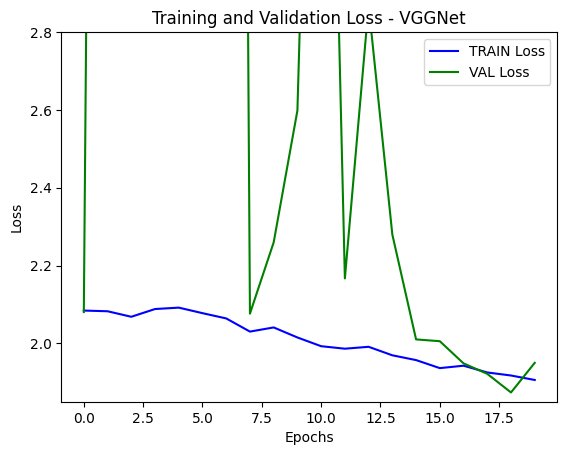

In [ ]:
checkpoint = torch.load('/content/model_VGGNet.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet', top_y=2.8, bottom_y=1.85)

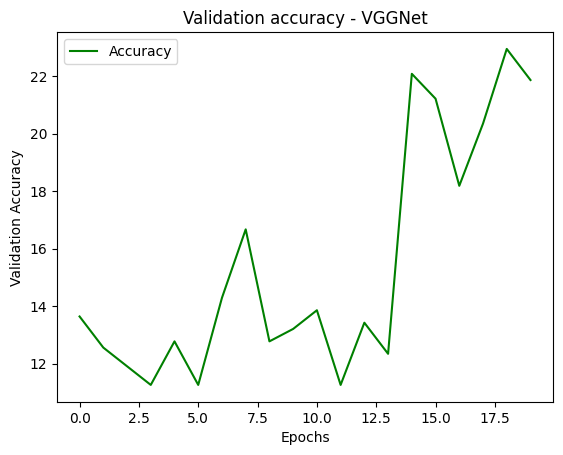

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet')

## Image Classification

### Config

In [ ]:
class Config_image_classification():
  batch_size = 64
  num_epochs = 20
  lr = 0.0005

### Training, Validation and Test Set creation

In [ ]:
# X immages for each class => 80% of X training - 10% of X validation - 10% of X test set

df_image_classification_train = pd.DataFrame(data=[], columns=['filename', 'class'])
df_image_classification_val = pd.DataFrame(data=[], columns=['filename', 'class'])
df_image_classification_test = pd.DataFrame(data=[], columns=['filename', 'class'])

for c in classes:
  total_images_for_class_c = len(df_image_classification.loc[df_image_classification['class'] == c])

  df_image_classification_train = pd.concat([df_image_classification_train, df_image_classification.loc[df_image_classification['class'] == c][: int(total_images_for_class_c * 0.8)]])
  df_image_classification_val = pd.concat([df_image_classification_val, df_image_classification.loc[df_image_classification['class'] == c][int(total_images_for_class_c * 0.8):int(total_images_for_class_c * 0.9)]])
  df_image_classification_test = pd.concat([df_image_classification_test, df_image_classification.loc[df_image_classification['class'] == c][int(total_images_for_class_c * 0.9):]])

In [ ]:
print(df_image_classification_train)

                                          filename      class
202   VOCdevkit/VOC2012/JPEGImages/2008_008050.jpg  aeroplane
203   VOCdevkit/VOC2012/JPEGImages/2008_008053.jpg  aeroplane
204   VOCdevkit/VOC2012/JPEGImages/2008_008086.jpg  aeroplane
205   VOCdevkit/VOC2012/JPEGImages/2008_008096.jpg  aeroplane
206   VOCdevkit/VOC2012/JPEGImages/2008_008130.jpg  aeroplane
...                                            ...        ...
7605  VOCdevkit/VOC2012/JPEGImages/2011_000309.jpg        cow
7606  VOCdevkit/VOC2012/JPEGImages/2011_000502.jpg        cow
7607  VOCdevkit/VOC2012/JPEGImages/2011_000548.jpg        cow
7608  VOCdevkit/VOC2012/JPEGImages/2011_000566.jpg        cow
7609  VOCdevkit/VOC2012/JPEGImages/2011_000609.jpg        cow

[4286 rows x 2 columns]


In [ ]:
print(df_image_classification_val)

                                          filename      class
581   VOCdevkit/VOC2012/JPEGImages/2010_006032.jpg  aeroplane
582   VOCdevkit/VOC2012/JPEGImages/2010_006034.jpg  aeroplane
583   VOCdevkit/VOC2012/JPEGImages/2010_006067.jpg  aeroplane
584   VOCdevkit/VOC2012/JPEGImages/2010_006082.jpg  aeroplane
585   VOCdevkit/VOC2012/JPEGImages/2011_000103.jpg  aeroplane
...                                            ...        ...
7627  VOCdevkit/VOC2012/JPEGImages/2011_001653.jpg        cow
7628  VOCdevkit/VOC2012/JPEGImages/2011_001679.jpg        cow
7629  VOCdevkit/VOC2012/JPEGImages/2011_001708.jpg        cow
7630  VOCdevkit/VOC2012/JPEGImages/2011_001782.jpg        cow
7631  VOCdevkit/VOC2012/JPEGImages/2011_001805.jpg        cow

[536 rows x 2 columns]


In [ ]:
print(df_image_classification_test)

                                          filename      class
628   VOCdevkit/VOC2012/JPEGImages/2011_001624.jpg  aeroplane
629   VOCdevkit/VOC2012/JPEGImages/2011_001647.jpg  aeroplane
630   VOCdevkit/VOC2012/JPEGImages/2011_001699.jpg  aeroplane
631   VOCdevkit/VOC2012/JPEGImages/2011_001753.jpg  aeroplane
632   VOCdevkit/VOC2012/JPEGImages/2011_001789.jpg  aeroplane
...                                            ...        ...
7649  VOCdevkit/VOC2012/JPEGImages/2011_002937.jpg        cow
7650  VOCdevkit/VOC2012/JPEGImages/2011_002979.jpg        cow
7651  VOCdevkit/VOC2012/JPEGImages/2011_003016.jpg        cow
7652  VOCdevkit/VOC2012/JPEGImages/2011_003019.jpg        cow
7653  VOCdevkit/VOC2012/JPEGImages/2011_003043.jpg        cow

[541 rows x 2 columns]


### MyDataset class



In [ ]:
class MyDataset(Dataset):
  def __init__(self, df, classes, transform=None):
      self.train_data = df.values
      self.classes = classes
      self.transform = transform

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = np.array(Image.open(self.train_data[index][0]).convert('RGB'))
    image_label = self.classes.index(self.train_data[index][1])

    if image.shape[0] != 222:
        image = skimage.transform.resize(image, (222, 222))
        image = img_as_float32(image)

    image_label = np.array(image_label).astype(np.int64)

    if self.transform:
      image = self.transform(image)

    return image, image_label

### Datasets Loaders

In [ ]:
##########################################################
#### Creating Train/Validation dataset and dataloader ####
##########################################################

traindataset = MyDataset(df_image_classification_train, classes,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config_image_classification.batch_size,
                                          shuffle=True)

valdataset = MyDataset(df_image_classification_val, classes,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config_image_classification.batch_size,
                                        shuffle=False)

testdataset = MyDataset(df_image_classification_test, classes,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
testloader = torch.utils.data.DataLoader(testdataset,
                                        batch_size=Config_image_classification.batch_size,
                                        shuffle=False)

### Datasets Visualization

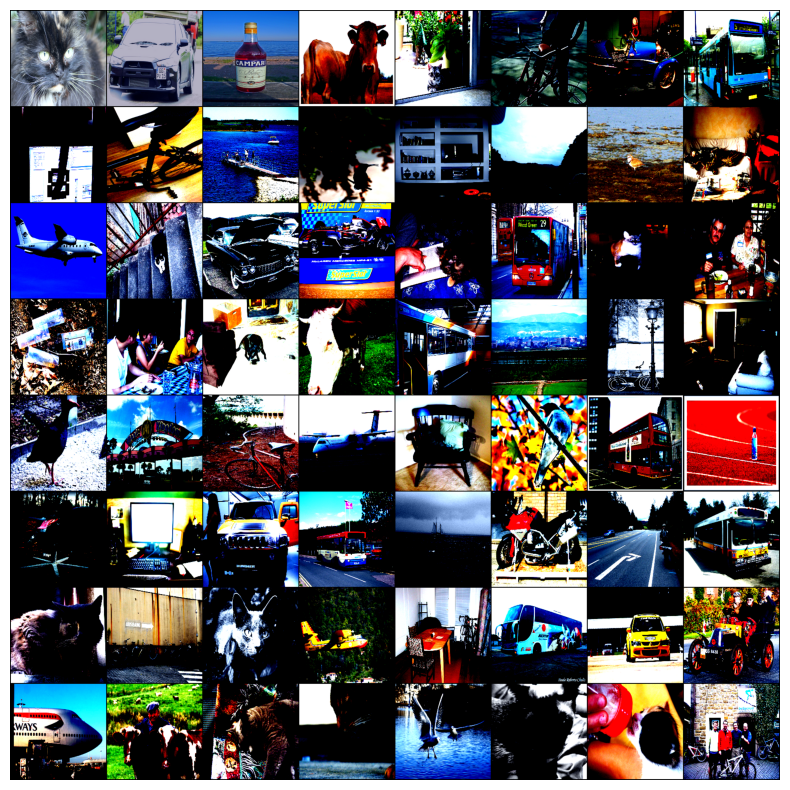

Labels: [7 6 4 9 7 1 6 5 7 1 3 2 4 6 2 8 0 7 6 6 7 5 1 4 4 4 8 9 5 2 1 8 2 6 1 0 8
 2 5 4 8 8 6 1 2 6 1 5 7 1 7 0 8 5 6 6 6 9 7 7 2 7 4 1]


In [ ]:
######################################
#### Visualizing training dataset ####
######################################

example_batch = next(iter(trainloader))
imshow(torchvision.utils.make_grid(unorm(example_batch[0])))
print(f'Labels: {example_batch[1].numpy()}')

### Useful functions

#### Training function

In [ ]:
##############################
# Training/Validation Engine #
##############################

def model_training(model, optimizer, criterion, scheduler, model_name):
  global_trn_loss = []
  global_val_loss = []
  accuracy = []

  for epoch in range(Config_image_classification.num_epochs):
      train_running_loss = []
      val_running_loss = []
      start_time = time.time()
      model.train()
      for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config_image_classification.batch_size)):
          image, image_label = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          output = model(image)
          loss = criterion(output, image_label)
          loss.backward()
          optimizer.step()
          
          train_running_loss.append(loss.item())
      else:
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset)/Config_image_classification.batch_size)):
            image, image_label = data[0].to(device), data[1].to(device)
            output = model(image)
            loss = criterion(output, image_label)
            val_running_loss.append(loss.item())
          
            _, predicted = torch.max(output.data, 1)
            total += image_label.size(0)
            correct += (predicted == image_label).sum()
          print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
          print('Val accuracy: {:.3f}%'.format(100 * correct / total))

      global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
      global_val_loss.append(sum(val_running_loss) / len(val_running_loss))
      accuracy.append(100 * correct / total)

      scheduler.step(global_val_loss[-1])

      print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
          epoch + 1, Config_image_classification.num_epochs, global_trn_loss[-1], global_val_loss[-1],
          (time.time() - start_time) / 60))
      
  MODEL_SAVE_PATH = f'/content/model_{model_name}.pt'
  torch.save(
    {
        'epoch': Config_image_classification.num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'global_trnloss': global_trn_loss,
        'global_valloss': global_val_loss,
        'accuracy' : accuracy
    }, MODEL_SAVE_PATH)

#### Testing function

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def score(y_true, y_pred):
  scores = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  average_scores = precision_recall_fscore_support(y_true, y_pred, average="macro")

  print("\nScores for each class:")
  for i, c in enumerate(classes):
    print(f'{c} => Precision: {scores[0][i]}, Recall: {scores[1][i]}, F-Score: {scores[2][i]}')
  
  print(f'\nAverage Precision: {average_scores[0]}, Average Recall: {average_scores[1]}, Average F-Score: {average_scores[2]}')
  

def model_testing(model):
  model.eval()

  total = 0
  correct = 0
  true_labels = []
  predicted_labels = []  

  with torch.no_grad():
    for data in testloader:
      image, image_label = data[0].to(device), data[1].to(device)
      output = model(image)
    
      _, predicted = torch.max(output.data, 1)
      total += image_label.size(0)
      correct += (predicted == image_label).sum().item()
      
      image_label = image_label.detach().cpu().numpy()
      predicted = predicted.detach().cpu().numpy()

      for i in range(len(image_label)):
        true_labels.append(image_label[i])
        predicted_labels.append(predicted[i])
    
  print('Test --- total:{}, correct:{}'.format(total, correct))
  print('Accuracy: {}%'.format(100 * correct / total))
  score(true_labels, predicted_labels)


### Models Training from scratch

#### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(2304, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

baseline_model = BaselineModel().to(device)

##### Baseline Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline_image_classification')

67it [02:05,  1.87s/it]
9it [00:14,  1.64s/it]


Val Progress --- total:536, correct:160
Val accuracy: 29.851%
Epoch [1/20], TRNLoss:1.9932, VALLoss:1.9317, Time:2.33


67it [01:53,  1.69s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:180
Val accuracy: 33.582%
Epoch [2/20], TRNLoss:1.7865, VALLoss:1.8683, Time:2.11


67it [01:52,  1.68s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:167
Val accuracy: 31.157%
Epoch [3/20], TRNLoss:1.6553, VALLoss:1.8954, Time:2.11


67it [01:52,  1.68s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:160
Val accuracy: 29.851%
Epoch [4/20], TRNLoss:1.5861, VALLoss:1.8456, Time:2.10


67it [01:52,  1.68s/it]
9it [00:14,  1.60s/it]


Val Progress --- total:536, correct:190
Val accuracy: 35.448%
Epoch [5/20], TRNLoss:1.4972, VALLoss:1.8635, Time:2.12


67it [01:52,  1.68s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:189
Val accuracy: 35.261%
Epoch [6/20], TRNLoss:1.4450, VALLoss:2.3323, Time:2.11


67it [01:53,  1.69s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:184
Val accuracy: 34.328%
Epoch [7/20], TRNLoss:1.3826, VALLoss:1.8716, Time:2.11


67it [01:51,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:168
Val accuracy: 31.343%
Epoch [8/20], TRNLoss:1.3389, VALLoss:2.7685, Time:2.09


67it [01:52,  1.68s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:213
Val accuracy: 39.739%
Epoch [9/20], TRNLoss:1.2216, VALLoss:1.7644, Time:2.10


67it [01:54,  1.71s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:203
Val accuracy: 37.873%
Epoch [10/20], TRNLoss:1.1652, VALLoss:1.7637, Time:2.14


67it [01:52,  1.68s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:226
Val accuracy: 42.164%
Epoch [11/20], TRNLoss:1.0638, VALLoss:1.8335, Time:2.10


67it [01:52,  1.68s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:170
Val accuracy: 31.716%
Epoch [12/20], TRNLoss:0.9928, VALLoss:2.6381, Time:2.11


67it [01:52,  1.67s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:227
Val accuracy: 42.351%
Epoch [13/20], TRNLoss:0.9179, VALLoss:2.1007, Time:2.10


67it [01:52,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:218
Val accuracy: 40.672%
Epoch [14/20], TRNLoss:0.8452, VALLoss:1.8819, Time:2.10


67it [01:51,  1.67s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:187
Val accuracy: 34.888%
Epoch [15/20], TRNLoss:0.8115, VALLoss:2.2393, Time:2.09


67it [01:51,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:232
Val accuracy: 43.284%
Epoch 00016: reducing learning rate of group 0 to 1.5000e-04.
Epoch [16/20], TRNLoss:0.6963, VALLoss:1.9043, Time:2.09


67it [01:51,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:226
Val accuracy: 42.164%
Epoch [17/20], TRNLoss:0.4947, VALLoss:2.3571, Time:2.09


67it [01:51,  1.66s/it]
9it [00:13,  1.49s/it]


Val Progress --- total:536, correct:223
Val accuracy: 41.604%
Epoch [18/20], TRNLoss:0.3825, VALLoss:2.5136, Time:2.08


67it [01:50,  1.65s/it]
9it [00:13,  1.49s/it]


Val Progress --- total:536, correct:225
Val accuracy: 41.978%
Epoch [19/20], TRNLoss:0.3310, VALLoss:2.5542, Time:2.07


67it [01:51,  1.66s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:225
Val accuracy: 41.978%
Epoch [20/20], TRNLoss:0.3090, VALLoss:2.5667, Time:2.08


##### Baseline Model training and validation plots

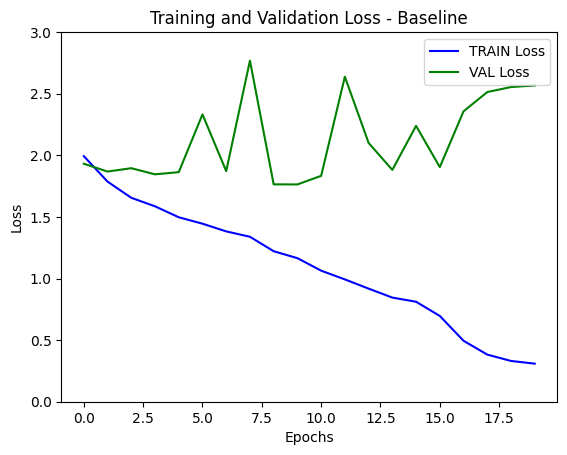

In [ ]:
checkpoint = torch.load('/content/model_baseline_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline', top_y=3, bottom_y=0)

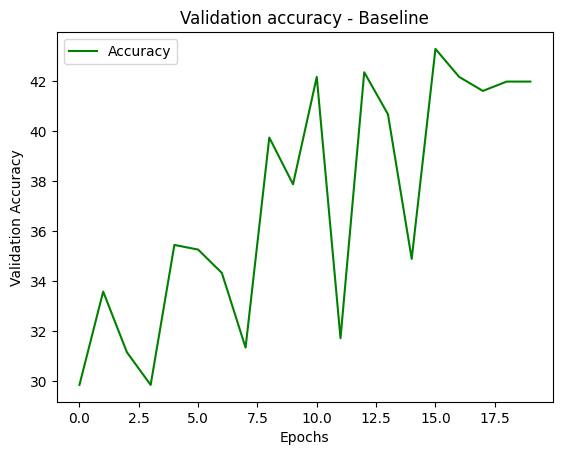

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline')

##### Baseline Model Testing

In [ ]:
baseline_model = BaselineModel().to(device)
baseline_model.load_state_dict(checkpoint['model_state_dict'])

model_testing(baseline_model)

Test --- total:541, correct:235
Accuracy: 43.438077634011094%

Scores for each class:
aeroplane => Precision: 0.6666666666666666, Recall: 0.5416666666666666, F-Score: 0.5977011494252873
bicycle => Precision: 0.375, Recall: 0.3, F-Score: 0.33333333333333326
bird => Precision: 0.43333333333333335, Recall: 0.4727272727272727, F-Score: 0.4521739130434783
boat => Precision: 0.42857142857142855, Recall: 0.32432432432432434, F-Score: 0.3692307692307692
bottle => Precision: 0.20833333333333334, Recall: 0.18518518518518517, F-Score: 0.19607843137254902
bus => Precision: 0.631578947368421, Recall: 0.3870967741935484, F-Score: 0.48000000000000004
car => Precision: 0.42045454545454547, Recall: 0.42528735632183906, F-Score: 0.4228571428571428
cat => Precision: 0.5227272727272727, Recall: 0.6052631578947368, F-Score: 0.5609756097560975
chair => Precision: 0.41379310344827586, Recall: 0.5274725274725275, F-Score: 0.463768115942029
cow => Precision: 0.2608695652173913, Recall: 0.2727272727272727, F-Sc

#### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(2304, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

alexnet_model = AlexNetwork().to(device)

##### AlexNet Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet_image_classification')

67it [01:55,  1.73s/it]
9it [00:14,  1.56s/it]


Val Progress --- total:536, correct:159
Val accuracy: 29.664%
Epoch [1/20], TRNLoss:2.0194, VALLoss:2.0287, Time:2.17


67it [01:51,  1.67s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:163
Val accuracy: 30.410%
Epoch [2/20], TRNLoss:1.8112, VALLoss:2.1187, Time:2.09


67it [01:51,  1.66s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:173
Val accuracy: 32.276%
Epoch [3/20], TRNLoss:1.7143, VALLoss:1.9950, Time:2.08


67it [01:51,  1.67s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:180
Val accuracy: 33.582%
Epoch [4/20], TRNLoss:1.6618, VALLoss:1.9227, Time:2.09


67it [01:53,  1.69s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:167
Val accuracy: 31.157%
Epoch [5/20], TRNLoss:1.6140, VALLoss:1.9656, Time:2.11


67it [01:52,  1.68s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:188
Val accuracy: 35.075%
Epoch [6/20], TRNLoss:1.5494, VALLoss:1.7324, Time:2.10


67it [01:51,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:211
Val accuracy: 39.366%
Epoch [7/20], TRNLoss:1.4674, VALLoss:1.7239, Time:2.09


67it [01:52,  1.67s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:198
Val accuracy: 36.940%
Epoch [8/20], TRNLoss:1.4213, VALLoss:1.7591, Time:2.09


67it [01:51,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:221
Val accuracy: 41.231%
Epoch [9/20], TRNLoss:1.3527, VALLoss:1.6934, Time:2.09


67it [01:51,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:142
Val accuracy: 26.493%
Epoch [10/20], TRNLoss:1.2759, VALLoss:2.7831, Time:2.09


67it [01:51,  1.67s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:221
Val accuracy: 41.231%
Epoch [11/20], TRNLoss:1.2290, VALLoss:1.7103, Time:2.10


67it [01:54,  1.70s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:189
Val accuracy: 35.261%
Epoch [12/20], TRNLoss:1.1930, VALLoss:2.0350, Time:2.13


67it [01:55,  1.73s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:223
Val accuracy: 41.604%
Epoch [13/20], TRNLoss:1.1011, VALLoss:1.8056, Time:2.16


67it [01:54,  1.71s/it]
9it [00:14,  1.59s/it]


Val Progress --- total:536, correct:228
Val accuracy: 42.537%
Epoch [14/20], TRNLoss:1.0399, VALLoss:1.8685, Time:2.14


67it [01:55,  1.72s/it]
9it [00:14,  1.59s/it]


Val Progress --- total:536, correct:190
Val accuracy: 35.448%
Epoch 00015: reducing learning rate of group 0 to 1.5000e-04.
Epoch [15/20], TRNLoss:0.9773, VALLoss:2.5920, Time:2.16


67it [01:57,  1.76s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:231
Val accuracy: 43.097%
Epoch [16/20], TRNLoss:0.7449, VALLoss:1.9965, Time:2.20


67it [01:55,  1.72s/it]
9it [00:14,  1.56s/it]


Val Progress --- total:536, correct:232
Val accuracy: 43.284%
Epoch [17/20], TRNLoss:0.5728, VALLoss:2.1734, Time:2.16


67it [01:53,  1.69s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:240
Val accuracy: 44.776%
Epoch [18/20], TRNLoss:0.5219, VALLoss:2.2650, Time:2.11


67it [01:52,  1.67s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:229
Val accuracy: 42.724%
Epoch [19/20], TRNLoss:0.4493, VALLoss:2.4977, Time:2.10


67it [01:53,  1.70s/it]
9it [00:14,  1.66s/it]


Val Progress --- total:536, correct:223
Val accuracy: 41.604%
Epoch [20/20], TRNLoss:0.4222, VALLoss:2.4214, Time:2.14


##### AlexNet Model training and validation plots

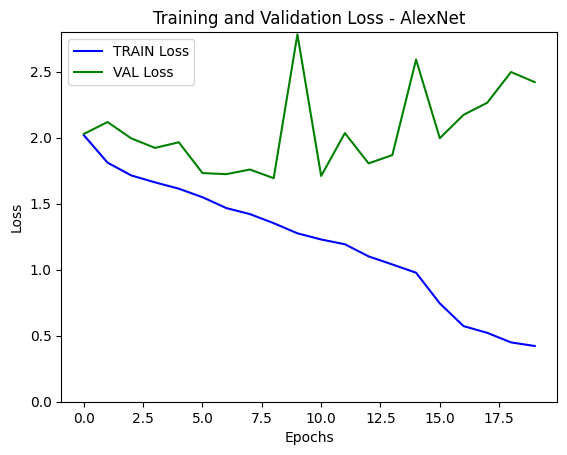

In [ ]:
checkpoint = torch.load('/content/model_alexnet_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet', top_y=2.8, bottom_y=0)

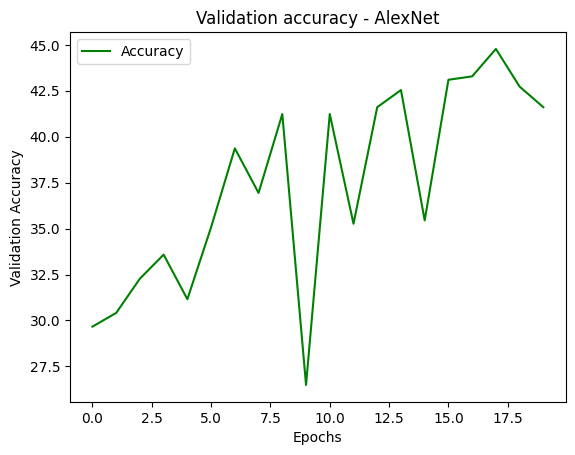

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet')

##### AlexNet Model Testing

In [ ]:
alexnet_model = AlexNetwork().to(device)
alexnet_model.load_state_dict(checkpoint['model_state_dict'])

model_testing(alexnet_model)

Test --- total:541, correct:225
Accuracy: 41.58964879852126%

Scores for each class:
aeroplane => Precision: 0.6153846153846154, Recall: 0.5, F-Score: 0.5517241379310345
bicycle => Precision: 0.3333333333333333, Recall: 0.2, F-Score: 0.25
bird => Precision: 0.417910447761194, Recall: 0.509090909090909, F-Score: 0.4590163934426229
boat => Precision: 0.42857142857142855, Recall: 0.40540540540540543, F-Score: 0.4166666666666667
bottle => Precision: 0.18888888888888888, Recall: 0.3148148148148148, F-Score: 0.23611111111111108
bus => Precision: 0.6, Recall: 0.3870967741935484, F-Score: 0.47058823529411764
car => Precision: 0.44047619047619047, Recall: 0.42528735632183906, F-Score: 0.4327485380116958
cat => Precision: 0.5857142857142857, Recall: 0.5394736842105263, F-Score: 0.5616438356164384
chair => Precision: 0.358695652173913, Recall: 0.3626373626373626, F-Score: 0.360655737704918
cow => Precision: 0.5, Recall: 0.45454545454545453, F-Score: 0.47619047619047616

Average Precision: 0.44689

#### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(18432, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

vgg_model = VggNet().to(device)

##### VGG Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'vgg_image_classification')

67it [02:43,  2.43s/it]
9it [00:15,  1.73s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [1/20], TRNLoss:2.1755, VALLoss:2.5394, Time:2.98


67it [02:38,  2.37s/it]
9it [00:15,  1.69s/it]


Val Progress --- total:536, correct:54
Val accuracy: 10.075%
Epoch [2/20], TRNLoss:2.0071, VALLoss:11.3870, Time:2.90


67it [02:40,  2.39s/it]
9it [00:15,  1.77s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [3/20], TRNLoss:1.8943, VALLoss:21.3664, Time:2.94


67it [02:38,  2.37s/it]
9it [00:15,  1.70s/it]


Val Progress --- total:536, correct:94
Val accuracy: 17.537%
Epoch [4/20], TRNLoss:1.8275, VALLoss:26.0870, Time:2.90


67it [02:40,  2.39s/it]
9it [00:15,  1.72s/it]


Val Progress --- total:536, correct:86
Val accuracy: 16.045%
Epoch [5/20], TRNLoss:1.8012, VALLoss:18.1209, Time:2.93


67it [02:37,  2.36s/it]
9it [00:15,  1.77s/it]


Val Progress --- total:536, correct:54
Val accuracy: 10.075%
Epoch [6/20], TRNLoss:1.7439, VALLoss:28.3835, Time:2.90


67it [02:38,  2.37s/it]
9it [00:15,  1.69s/it]


Val Progress --- total:536, correct:76
Val accuracy: 14.179%
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.
Epoch [7/20], TRNLoss:1.6871, VALLoss:27.1241, Time:2.90


67it [02:36,  2.34s/it]
9it [00:15,  1.76s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [8/20], TRNLoss:1.5649, VALLoss:11.5467, Time:2.88


67it [02:37,  2.34s/it]
9it [00:15,  1.67s/it]


Val Progress --- total:536, correct:86
Val accuracy: 16.045%
Epoch [9/20], TRNLoss:1.4921, VALLoss:11.7026, Time:2.87


67it [02:39,  2.38s/it]
9it [00:15,  1.70s/it]


Val Progress --- total:536, correct:92
Val accuracy: 17.164%
Epoch [10/20], TRNLoss:1.4724, VALLoss:19.6763, Time:2.91


67it [02:39,  2.38s/it]
9it [00:15,  1.77s/it]


Val Progress --- total:536, correct:91
Val accuracy: 16.978%
Epoch [11/20], TRNLoss:1.4416, VALLoss:4.5265, Time:2.92


67it [02:38,  2.37s/it]
9it [00:15,  1.71s/it]


Val Progress --- total:536, correct:88
Val accuracy: 16.418%
Epoch [12/20], TRNLoss:1.3936, VALLoss:10.6180, Time:2.90


67it [02:37,  2.36s/it]
9it [00:15,  1.68s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch 00013: reducing learning rate of group 0 to 4.5000e-05.
Epoch [13/20], TRNLoss:1.3644, VALLoss:8.1989, Time:2.88


67it [02:38,  2.37s/it]
9it [00:16,  1.78s/it]


Val Progress --- total:536, correct:169
Val accuracy: 31.530%
Epoch [14/20], TRNLoss:1.2674, VALLoss:2.0970, Time:2.91


67it [02:37,  2.35s/it]
9it [00:15,  1.72s/it]


Val Progress --- total:536, correct:102
Val accuracy: 19.030%
Epoch [15/20], TRNLoss:1.2176, VALLoss:6.8053, Time:2.88


67it [02:39,  2.38s/it]
9it [00:15,  1.68s/it]


Val Progress --- total:536, correct:37
Val accuracy: 6.903%
Epoch [16/20], TRNLoss:1.1961, VALLoss:5.9342, Time:2.90


67it [02:36,  2.34s/it]
9it [00:15,  1.70s/it]


Val Progress --- total:536, correct:101
Val accuracy: 18.843%
Epoch [17/20], TRNLoss:1.1676, VALLoss:7.3416, Time:2.87


67it [02:40,  2.39s/it]
9it [00:15,  1.68s/it]


Val Progress --- total:536, correct:58
Val accuracy: 10.821%
Epoch [18/20], TRNLoss:1.1508, VALLoss:7.8847, Time:2.92


67it [02:36,  2.34s/it]
9it [00:15,  1.74s/it]


Val Progress --- total:536, correct:154
Val accuracy: 28.731%
Epoch [19/20], TRNLoss:1.1192, VALLoss:6.6263, Time:2.88


67it [02:37,  2.35s/it]
9it [00:15,  1.68s/it]


Val Progress --- total:536, correct:112
Val accuracy: 20.896%
Epoch 00020: reducing learning rate of group 0 to 1.3500e-05.
Epoch [20/20], TRNLoss:1.0800, VALLoss:4.8578, Time:2.87


##### VGG Model training and validation plots

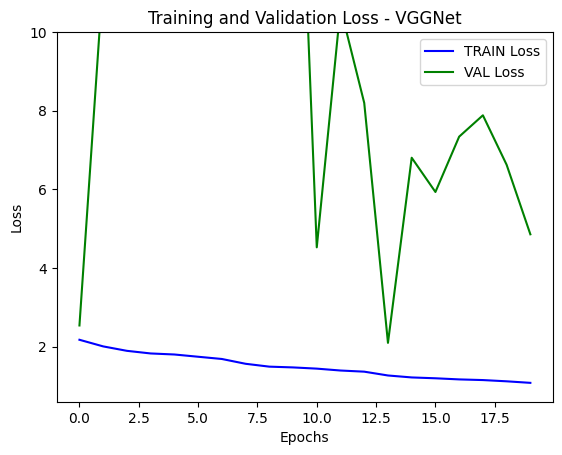

In [ ]:
checkpoint = torch.load('/content/model_vgg_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet', top_y=10, bottom_y=0.6)

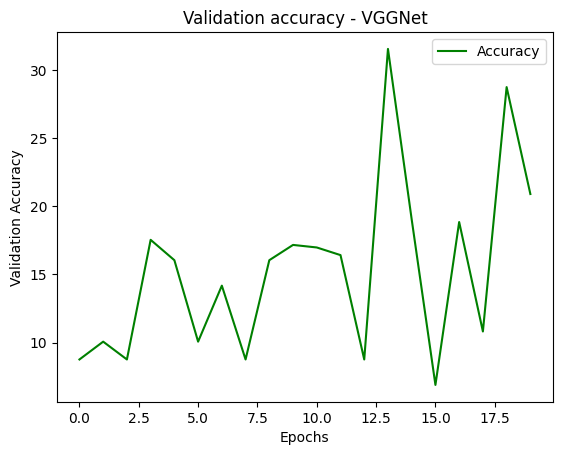

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet')

##### VGG Model Testing

In [ ]:
vgg_model = VggNet().to(device)
vgg_model.load_state_dict(checkpoint['model_state_dict'])

model_testing(vgg_model)

Test --- total:541, correct:105
Accuracy: 19.408502772643253%

Scores for each class:
aeroplane => Precision: 1.0, Recall: 0.041666666666666664, F-Score: 0.07999999999999999
bicycle => Precision: 0.0, Recall: 0.0, F-Score: 0.0
bird => Precision: 1.0, Recall: 0.01818181818181818, F-Score: 0.03571428571428572
boat => Precision: 0.0, Recall: 0.0, F-Score: 0.0
bottle => Precision: 0.0, Recall: 0.0, F-Score: 0.0
bus => Precision: 0.375, Recall: 0.2903225806451613, F-Score: 0.3272727272727273
car => Precision: 0.23529411764705882, Recall: 0.04597701149425287, F-Score: 0.07692307692307693
cat => Precision: 0.0, Recall: 0.0, F-Score: 0.0
chair => Precision: 0.18237704918032788, Recall: 0.978021978021978, F-Score: 0.307426597582038
cow => Precision: 0.0, Recall: 0.0, F-Score: 0.0

Average Precision: 0.2792671166827387, Average Recall: 0.1374170055009877, Average F-Score: 0.0827336687492128


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Models Training with Transfer Learning

#### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel_3x3(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel_3x3, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(2304, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/VOC/ContextPrediction/Baseline/model_baseline.pt', map_location='cuda')

baseline_model = BaselineModel_3x3().to(device)
baseline_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
baseline_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

baseline_model = baseline_model.to(device)

##### Baseline Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline_3x3_image_classification')

67it [01:54,  1.71s/it]
9it [00:15,  1.70s/it]


Val Progress --- total:536, correct:190
Val accuracy: 35.448%
Epoch [1/20], TRNLoss:2.0015, VALLoss:2.1284, Time:2.17


67it [01:52,  1.68s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:178
Val accuracy: 33.209%
Epoch [2/20], TRNLoss:1.7425, VALLoss:1.8411, Time:2.10


67it [01:52,  1.68s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:176
Val accuracy: 32.836%
Epoch [3/20], TRNLoss:1.6477, VALLoss:1.8859, Time:2.11


67it [01:52,  1.68s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:195
Val accuracy: 36.381%
Epoch [4/20], TRNLoss:1.5411, VALLoss:2.0225, Time:2.10


67it [01:52,  1.67s/it]
9it [00:14,  1.58s/it]


Val Progress --- total:536, correct:190
Val accuracy: 35.448%
Epoch [5/20], TRNLoss:1.4507, VALLoss:1.8639, Time:2.11


67it [01:55,  1.72s/it]
9it [00:14,  1.58s/it]


Val Progress --- total:536, correct:207
Val accuracy: 38.619%
Epoch [6/20], TRNLoss:1.3445, VALLoss:1.8649, Time:2.16


67it [01:53,  1.69s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:215
Val accuracy: 40.112%
Epoch [7/20], TRNLoss:1.2312, VALLoss:1.8148, Time:2.12


67it [01:52,  1.68s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:145
Val accuracy: 27.052%
Epoch [8/20], TRNLoss:1.1353, VALLoss:5.4552, Time:2.10


67it [01:53,  1.69s/it]
9it [00:14,  1.56s/it]


Val Progress --- total:536, correct:204
Val accuracy: 38.060%
Epoch [9/20], TRNLoss:1.0625, VALLoss:1.9126, Time:2.13


67it [01:55,  1.72s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:176
Val accuracy: 32.836%
Epoch [10/20], TRNLoss:0.9809, VALLoss:2.1395, Time:2.15


67it [01:52,  1.68s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:209
Val accuracy: 38.993%
Epoch [11/20], TRNLoss:0.8975, VALLoss:2.0373, Time:2.10


67it [01:52,  1.68s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:207
Val accuracy: 38.619%
Epoch [12/20], TRNLoss:0.8194, VALLoss:2.2890, Time:2.11


67it [01:53,  1.70s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:188
Val accuracy: 35.075%
Epoch 00013: reducing learning rate of group 0 to 1.5000e-04.
Epoch [13/20], TRNLoss:0.7109, VALLoss:2.3636, Time:2.12


67it [01:54,  1.70s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:208
Val accuracy: 38.806%
Epoch [14/20], TRNLoss:0.4932, VALLoss:2.4774, Time:2.13


67it [01:54,  1.71s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:205
Val accuracy: 38.246%
Epoch [15/20], TRNLoss:0.3560, VALLoss:2.8442, Time:2.14


67it [01:52,  1.69s/it]
9it [00:13,  1.51s/it]


Val Progress --- total:536, correct:198
Val accuracy: 36.940%
Epoch [16/20], TRNLoss:0.3057, VALLoss:3.0300, Time:2.11


67it [01:52,  1.67s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:213
Val accuracy: 39.739%
Epoch [17/20], TRNLoss:0.2852, VALLoss:3.0692, Time:2.10


67it [01:54,  1.70s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:213
Val accuracy: 39.739%
Epoch [18/20], TRNLoss:0.2649, VALLoss:3.2457, Time:2.13


67it [01:54,  1.70s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:207
Val accuracy: 38.619%
Epoch 00019: reducing learning rate of group 0 to 4.5000e-05.
Epoch [19/20], TRNLoss:0.2538, VALLoss:3.1881, Time:2.13


67it [01:53,  1.69s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:211
Val accuracy: 39.366%
Epoch [20/20], TRNLoss:0.1981, VALLoss:3.3233, Time:2.12


##### Baseline Model training and validation plots

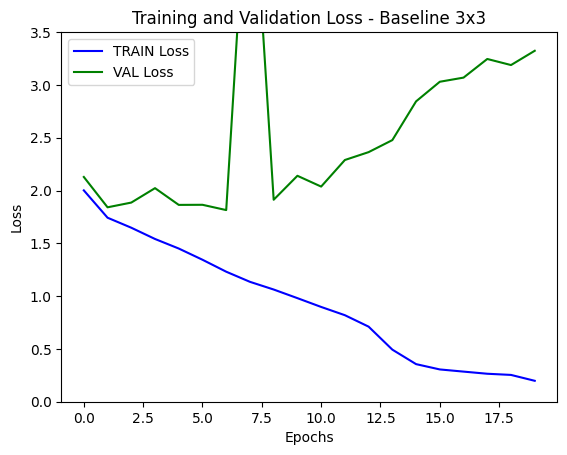

In [ ]:
checkpoint = torch.load('/content/model_baseline_3x3_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline 3x3', top_y=3.5, bottom_y=0)

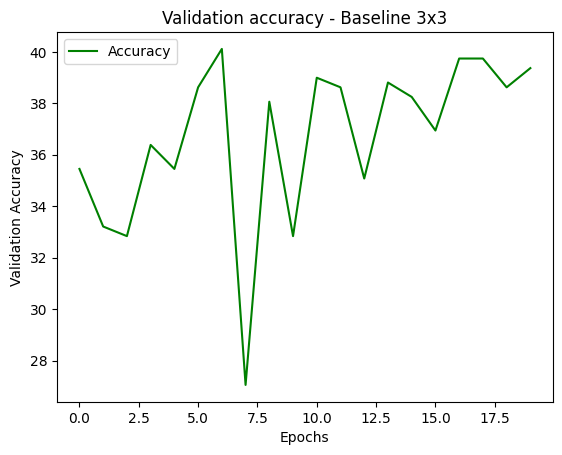

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline 3x3')

##### Baseline Model Testing

In [ ]:
model_testing(baseline_model)

Test --- total:541, correct:226
Accuracy: 41.77449168207024%

Scores for each class:
aeroplane => Precision: 0.6764705882352942, Recall: 0.4791666666666667, F-Score: 0.5609756097560975
bicycle => Precision: 0.25925925925925924, Recall: 0.175, F-Score: 0.208955223880597
bird => Precision: 0.48214285714285715, Recall: 0.4909090909090909, F-Score: 0.4864864864864865
boat => Precision: 0.48148148148148145, Recall: 0.35135135135135137, F-Score: 0.40625
bottle => Precision: 0.2909090909090909, Recall: 0.2962962962962963, F-Score: 0.2935779816513761
bus => Precision: 0.6, Recall: 0.2903225806451613, F-Score: 0.3913043478260869
car => Precision: 0.3359375, Recall: 0.4942528735632184, F-Score: 0.4
cat => Precision: 0.47191011235955055, Recall: 0.5526315789473685, F-Score: 0.5090909090909091
chair => Precision: 0.4270833333333333, Recall: 0.45054945054945056, F-Score: 0.4385026737967914
cow => Precision: 0.35714285714285715, Recall: 0.22727272727272727, F-Score: 0.2777777777777778

Average Preci

#### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork_3x3(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork_3x3, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(2304, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/VOC/ContextPrediction/AlexNet/model_alexnet.pt', map_location='cuda')

alexnet_model = AlexNetwork_3x3().to(device)
alexnet_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
alexnet_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

alexnet_model = alexnet_model.to(device)

##### AlexNet Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet_3x3_image_classification')

67it [02:11,  1.96s/it]
9it [00:14,  1.61s/it]


Val Progress --- total:536, correct:152
Val accuracy: 28.358%
Epoch [1/20], TRNLoss:2.0203, VALLoss:2.1695, Time:2.43


67it [01:52,  1.67s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:167
Val accuracy: 31.157%
Epoch [2/20], TRNLoss:1.8022, VALLoss:1.9126, Time:2.10


67it [01:58,  1.77s/it]
9it [00:14,  1.57s/it]


Val Progress --- total:536, correct:188
Val accuracy: 35.075%
Epoch [3/20], TRNLoss:1.6903, VALLoss:1.9604, Time:2.21


67it [01:52,  1.67s/it]
9it [00:13,  1.50s/it]


Val Progress --- total:536, correct:192
Val accuracy: 35.821%
Epoch [4/20], TRNLoss:1.6155, VALLoss:1.9256, Time:2.09


67it [01:52,  1.68s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:186
Val accuracy: 34.701%
Epoch [5/20], TRNLoss:1.5577, VALLoss:1.8918, Time:2.11


67it [01:54,  1.70s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:192
Val accuracy: 35.821%
Epoch [6/20], TRNLoss:1.4983, VALLoss:1.8652, Time:2.14


67it [01:52,  1.67s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:175
Val accuracy: 32.649%
Epoch [7/20], TRNLoss:1.4520, VALLoss:1.8908, Time:2.10


67it [01:56,  1.73s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:180
Val accuracy: 33.582%
Epoch [8/20], TRNLoss:1.3704, VALLoss:1.9212, Time:2.17


67it [01:58,  1.77s/it]
9it [00:15,  1.69s/it]


Val Progress --- total:536, correct:184
Val accuracy: 34.328%
Epoch [9/20], TRNLoss:1.3436, VALLoss:2.2368, Time:2.23


67it [01:57,  1.75s/it]
9it [00:14,  1.64s/it]


Val Progress --- total:536, correct:214
Val accuracy: 39.925%
Epoch [10/20], TRNLoss:1.2775, VALLoss:1.8691, Time:2.20


67it [01:57,  1.75s/it]
9it [00:14,  1.65s/it]


Val Progress --- total:536, correct:180
Val accuracy: 33.582%
Epoch [11/20], TRNLoss:1.2034, VALLoss:2.1814, Time:2.20


67it [01:55,  1.73s/it]
9it [00:13,  1.55s/it]


Val Progress --- total:536, correct:193
Val accuracy: 36.007%
Epoch 00012: reducing learning rate of group 0 to 1.5000e-04.
Epoch [12/20], TRNLoss:1.1185, VALLoss:2.2857, Time:2.16


67it [01:53,  1.69s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:226
Val accuracy: 42.164%
Epoch [13/20], TRNLoss:0.8835, VALLoss:1.8283, Time:2.12


67it [01:53,  1.69s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:205
Val accuracy: 38.246%
Epoch [14/20], TRNLoss:0.7465, VALLoss:2.1248, Time:2.12


67it [01:54,  1.70s/it]
9it [00:13,  1.52s/it]


Val Progress --- total:536, correct:211
Val accuracy: 39.366%
Epoch [15/20], TRNLoss:0.6668, VALLoss:2.3366, Time:2.13


67it [01:53,  1.70s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:223
Val accuracy: 41.604%
Epoch [16/20], TRNLoss:0.6057, VALLoss:2.4003, Time:2.13


67it [01:53,  1.70s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:210
Val accuracy: 39.179%
Epoch [17/20], TRNLoss:0.5527, VALLoss:2.5295, Time:2.12


67it [01:53,  1.69s/it]
9it [00:14,  1.57s/it]


Val Progress --- total:536, correct:222
Val accuracy: 41.418%
Epoch [18/20], TRNLoss:0.5340, VALLoss:2.4743, Time:2.12


67it [01:57,  1.75s/it]
9it [00:13,  1.54s/it]


Val Progress --- total:536, correct:218
Val accuracy: 40.672%
Epoch 00019: reducing learning rate of group 0 to 4.5000e-05.
Epoch [19/20], TRNLoss:0.4780, VALLoss:2.7294, Time:2.18


67it [01:53,  1.69s/it]
9it [00:13,  1.53s/it]


Val Progress --- total:536, correct:225
Val accuracy: 41.978%
Epoch [20/20], TRNLoss:0.3624, VALLoss:2.8043, Time:2.12


##### AlexNet Model training and validation plots

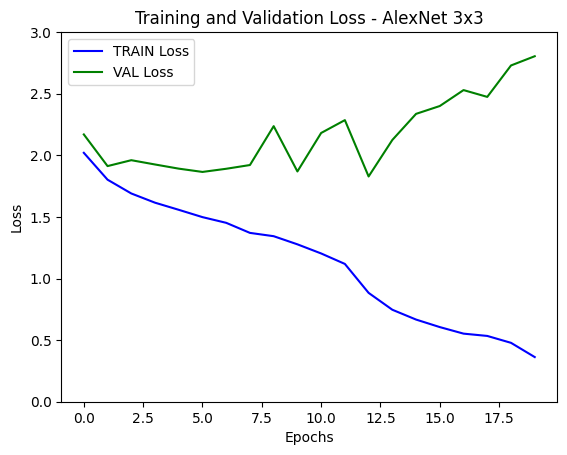

In [ ]:
checkpoint = torch.load('/content/model_alexnet_3x3_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet 3x3', top_y=3, bottom_y=0)

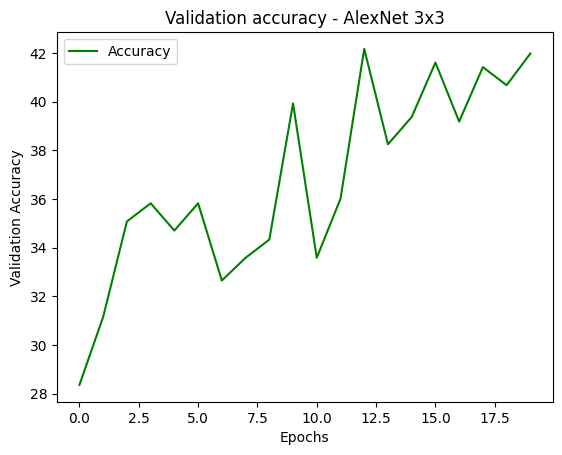

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet 3x3')

##### AlexNet Model Testing

In [ ]:
model_testing(alexnet_model)

Test --- total:541, correct:234
Accuracy: 43.253234750462106%

Scores for each class:
aeroplane => Precision: 0.6666666666666666, Recall: 0.4583333333333333, F-Score: 0.5432098765432098
bicycle => Precision: 0.38095238095238093, Recall: 0.2, F-Score: 0.2622950819672132
bird => Precision: 0.4032258064516129, Recall: 0.45454545454545453, F-Score: 0.42735042735042733
boat => Precision: 0.4857142857142857, Recall: 0.4594594594594595, F-Score: 0.47222222222222227
bottle => Precision: 0.24, Recall: 0.2222222222222222, F-Score: 0.23076923076923075
bus => Precision: 0.5789473684210527, Recall: 0.3548387096774194, F-Score: 0.44000000000000006
car => Precision: 0.4065934065934066, Recall: 0.42528735632183906, F-Score: 0.4157303370786517
cat => Precision: 0.5222222222222223, Recall: 0.618421052631579, F-Score: 0.5662650602409638
chair => Precision: 0.39669421487603307, Recall: 0.5274725274725275, F-Score: 0.4528301886792453
cow => Precision: 0.3684210526315789, Recall: 0.3181818181818182, F-Score

#### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet_3x3(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet_3x3, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(18432, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/VOC/ContextPrediction/VGG/model_VGGNet.pt', map_location='cuda')

vgg_model = VggNet_3x3().to(device)
vgg_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
vgg_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

vgg_model = vgg_model.to(device)

##### VGG Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'VGGNet_3x3_image_classification')

67it [02:43,  2.44s/it]
9it [00:15,  1.74s/it]


Val Progress --- total:536, correct:100
Val accuracy: 18.657%
Epoch [1/20], TRNLoss:2.0819, VALLoss:6.3622, Time:2.98


67it [02:38,  2.37s/it]
9it [00:15,  1.70s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [2/20], TRNLoss:1.9804, VALLoss:15.8492, Time:2.90


67it [02:38,  2.36s/it]
9it [00:16,  1.81s/it]


Val Progress --- total:536, correct:76
Val accuracy: 14.179%
Epoch [3/20], TRNLoss:1.9195, VALLoss:15.9513, Time:2.91


67it [02:39,  2.39s/it]
9it [00:15,  1.73s/it]


Val Progress --- total:536, correct:103
Val accuracy: 19.216%
Epoch [4/20], TRNLoss:1.8687, VALLoss:4.2194, Time:2.92


67it [02:39,  2.39s/it]
9it [00:15,  1.75s/it]


Val Progress --- total:536, correct:76
Val accuracy: 14.179%
Epoch [5/20], TRNLoss:1.8401, VALLoss:12.6602, Time:2.93


67it [02:45,  2.48s/it]
9it [00:16,  1.79s/it]


Val Progress --- total:536, correct:54
Val accuracy: 10.075%
Epoch [6/20], TRNLoss:1.8020, VALLoss:48.0199, Time:3.03


67it [02:43,  2.43s/it]
9it [00:15,  1.71s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [7/20], TRNLoss:1.8388, VALLoss:16.9334, Time:2.98


67it [02:40,  2.39s/it]
9it [00:15,  1.71s/it]


Val Progress --- total:536, correct:93
Val accuracy: 17.351%
Epoch [8/20], TRNLoss:1.8500, VALLoss:2.3609, Time:2.93


67it [02:38,  2.37s/it]
9it [00:16,  1.78s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [9/20], TRNLoss:1.7700, VALLoss:10.2080, Time:2.92


67it [02:39,  2.39s/it]
9it [00:15,  1.71s/it]


Val Progress --- total:536, correct:152
Val accuracy: 28.358%
Epoch [10/20], TRNLoss:1.7354, VALLoss:2.1387, Time:2.92


67it [02:40,  2.39s/it]
9it [00:15,  1.72s/it]


Val Progress --- total:536, correct:185
Val accuracy: 34.515%
Epoch [11/20], TRNLoss:1.7022, VALLoss:1.9327, Time:2.93


67it [02:39,  2.38s/it]
9it [00:15,  1.71s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [12/20], TRNLoss:1.6774, VALLoss:109.2532, Time:2.92


67it [02:39,  2.38s/it]
9it [00:17,  1.89s/it]


Val Progress --- total:536, correct:181
Val accuracy: 33.769%
Epoch [13/20], TRNLoss:1.6641, VALLoss:2.2788, Time:2.94


67it [02:43,  2.44s/it]
9it [00:16,  1.87s/it]


Val Progress --- total:536, correct:192
Val accuracy: 35.821%
Epoch [14/20], TRNLoss:1.6401, VALLoss:1.8861, Time:3.01


67it [02:39,  2.39s/it]
9it [00:15,  1.69s/it]


Val Progress --- total:536, correct:47
Val accuracy: 8.769%
Epoch [15/20], TRNLoss:1.6052, VALLoss:113.3286, Time:2.92


67it [02:39,  2.38s/it]
9it [00:15,  1.73s/it]


Val Progress --- total:536, correct:66
Val accuracy: 12.313%
Epoch [16/20], TRNLoss:1.6085, VALLoss:3.4115, Time:2.91


67it [02:40,  2.39s/it]
9it [00:15,  1.72s/it]


Val Progress --- total:536, correct:100
Val accuracy: 18.657%
Epoch [17/20], TRNLoss:1.6021, VALLoss:3.3278, Time:2.93


67it [02:39,  2.37s/it]
9it [00:16,  1.79s/it]


Val Progress --- total:536, correct:128
Val accuracy: 23.881%
Epoch [18/20], TRNLoss:1.5598, VALLoss:2.7746, Time:2.92


67it [02:38,  2.37s/it]
9it [00:16,  1.79s/it]


Val Progress --- total:536, correct:190
Val accuracy: 35.448%
Epoch [19/20], TRNLoss:1.5313, VALLoss:1.8851, Time:2.92


67it [02:43,  2.44s/it]
9it [00:15,  1.75s/it]


Val Progress --- total:536, correct:141
Val accuracy: 26.306%
Epoch [20/20], TRNLoss:1.5085, VALLoss:2.7917, Time:2.99


##### VGG Model training and validation plots

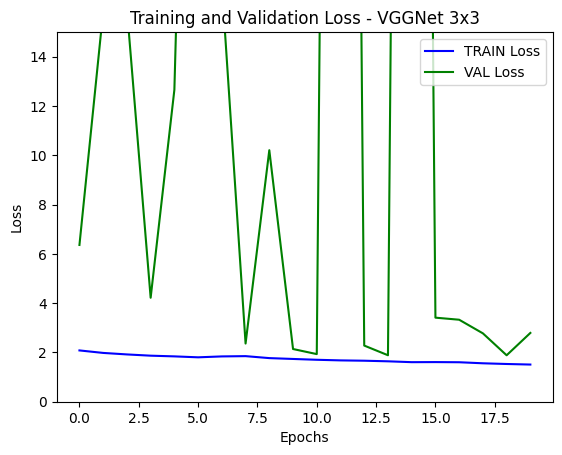

In [ ]:
checkpoint = torch.load('/content/model_VGGNet_3x3_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet 3x3', top_y=15, bottom_y=0)

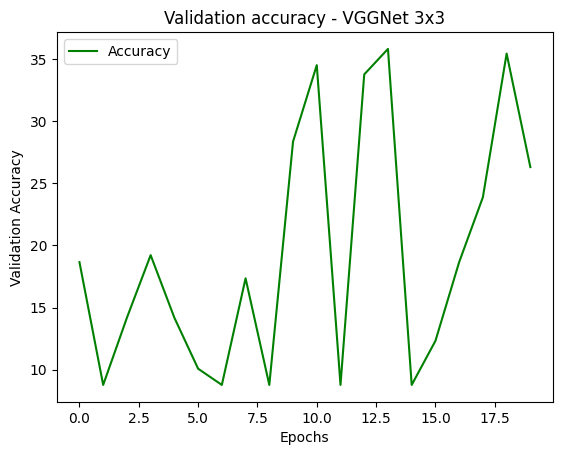

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet 3x3')

##### VGG Model Testing

In [ ]:
model_testing(vgg_model)

Test --- total:541, correct:140
Accuracy: 25.87800369685767%

Scores for each class:
aeroplane => Precision: 0.37, Recall: 0.7708333333333334, F-Score: 0.5
bicycle => Precision: 0.16666666666666666, Recall: 0.05, F-Score: 0.07692307692307691
bird => Precision: 0.5, Recall: 0.01818181818181818, F-Score: 0.03508771929824561
boat => Precision: 0.0, Recall: 0.0, F-Score: 0.0
bottle => Precision: 0.0, Recall: 0.0, F-Score: 0.0
bus => Precision: 0.0, Recall: 0.0, F-Score: 0.0
car => Precision: 0.22364217252396165, Recall: 0.8045977011494253, F-Score: 0.35000000000000003
cat => Precision: 0.0, Recall: 0.0, F-Score: 0.0
chair => Precision: 0.2631578947368421, Recall: 0.32967032967032966, F-Score: 0.2926829268292683
cow => Precision: 0.0, Recall: 0.0, F-Score: 0.0

Average Precision: 0.15234667339274705, Average Recall: 0.19732831823349065, Average F-Score: 0.12546937230505908


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
